In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
times = pd.read_excel(external_dir/'aurisano_times_ivt_out.xlsx')


In [4]:
times = (times
 .assign(Parent = lambda x: x['Chemical name'].ffill())
)

In [5]:
times = (times
 .assign(Parent_id = lambda df: df['Chemical name'].apply(
        lambda x: 'Parent' if isinstance(x, str)  else x
    ))
)

In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

import networkx as nx

In [7]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [8]:
newlst = []

# Sort the DataFrame by 'Parent' and any other relevant column, such as 'Level of generation'
times = times.sort_values(by=['Parent', 'Level of generation']).reset_index(drop=True)

# Iterate over each group
for i, group in times.groupby('Parent'):
    subset = group[['Parent', 'Parent_id']]
    # Define a counter for generating unique identifiers
    counter = 1
    # Iterate over rows in the subset
    for index, row in subset.iterrows():
        if row['Parent_id'] == 'Parent':
            newlst.append(row['Parent'])  # Use the parent ID as is
        else:
            # Append with a unique identifier based on the counter
            newlst.append(row['Parent'] + '_m_' + str(counter))
            # Increment the counter
            counter += 1

In [9]:
len(newlst)

54181

In [10]:
times.shape

(54181, 22)

In [11]:
times['ID'] = newlst

In [12]:
times.columns

Index(['#', 'ID of metabolite', 'Level of generation', 'Predecessor ID', 'CAS',
       'Chemical name', 'SMILES', 'Observed map/metabolite',
       'Transformation name', 'Transformation No', 'Transformation ID',
       'Transformation probability group', 'Transformation expert group',
       'Transformation type', 'Transformation probability', 'Used probability',
       'Enzyme(s)', 'Quantity of metabolite', 'Total quantity of metabolite',
       'Number of repetitions', 'Parent', 'Parent_id', 'ID'],
      dtype='object')

In [13]:
inchi_keys = {}
errors = []
for k,v in zip(times['ID'], times['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X


[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefined stereo

[13:15:51] WARNING: Omitted undefi

In [14]:
len(inchi_keys)

53933

In [15]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

times = pd.merge(times, df_inchi, on = 'ID', how = 'left')

In [16]:
times1 = (times
 .rename(columns=lambda col: col.replace(' ', '_'))
 .assign(transformation = lambda df : df['Transformation_name'].apply(
        lambda x: x.split('|')[0] if isinstance(x, str) and '|' in x else x
    )) 
 .filter(items = ['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',  'Chemical_name', 'SMILES',  'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation'])
)

In [17]:
times1

,ID_of_metabolite,Level_of_generation,Predecessor_ID,Chemical_name,SMILES,Parent,Parent_id,ID,INCHI_KEY,transformation
0,1,0,-,DTXSID001004378,CC(C)(C)C1CCC(OC(=O)C=C)CC1,DTXSID001004378,Parent,DTXSID001004378,LAIJAUHBAWLPCO-UHFFFAOYSA-N,NaN
1,2,1,1,NaN,CC(C)(C)C1CCC(O)CC1,DTXSID001004378,NaN,DTXSID001004378_m_1,CCOQPGVQAWPUPE-UHFFFAOYSA-N,Hydrolysis
2,3,1,1,NaN,C=CC(O)=O,DTXSID001004378,NaN,DTXSID001004378_m_2,NIXOWILDQLNWCW-UHFFFAOYSA-N,Hydrolysis
3,4,1,1,NaN,CC(C(=O)OC1CCC(C(C)(C)C)CC1)SCC(C(=O)NCC(O)=O)...,DTXSID001004378,NaN,DTXSID001004378_m_3,PEYQVWQWNWQRSE-UHFFFAOYSA-N,Glutathione Conjugation
4,5,1,1,NaN,CC(C)(C)C1CCC(OC(=O)CCSCC(C(=O)NCC(O)=O)NC(=O)...,DTXSID001004378,NaN,DTXSID001004378_m_4,DXZJGNKPEVWAPG-UHFFFAOYSA-N,Glutathione Conjugation
...,...,...,...,...,...,...,...,...,...,...
54176,16,3,12,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1cc2ccccc2cc1C(O)=Nc1...,DTXSID90998205,NaN,DTXSID90998205_m_21,JNNPCPSQJAUVDT-UHFFFAOYSA-N,O-Glucuronidation
54177,19,3,17,NaN,Oc1cc2ccccc2cc1C(=O)Nc1cc2c(cc1O)NC(=O)N2,DTXSID90998205,NaN,DTXSID90998205_m_22,SQLJIJRFRJKSKP-UHFFFAOYSA-N,Aromatic C-Hydroxylation
54178,20,3,18,NaN,OC1C(O)C(O)C(C(O)=O)OC1OC1Nc2cc(NC(=O)c3cc4ccc...,DTXSID90998205,NaN,DTXSID90998205_m_23,FDWIXPUXMKZQPN-UHFFFAOYSA-N,O-Glucuronidation
54179,21,3,18,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1cc2c(cc1NC(=O)c1cc3c...,DTXSID90998205,NaN,DTXSID90998205_m_24,QZGHPBAMPGZKIJ-UHFFFAOYSA-N,O-Glucuronidation


In [18]:
times1.to_csv(raw_dir/'times_toxval_metabolism.csv')

In [19]:
transformation_types = times1['transformation'].unique().tolist()

In [20]:
n_transformations= len(transformation_types)

In [21]:
edges = times1[times1['Predecessor_ID'] != '-']

In [22]:
times1['mol'] = [Chem.MolFromSmiles(e) for e in times1['SMILES']]

[13:16:41] SMILES Parse Error: syntax error while parsing: [O-2].[Ca+2].[O-2].[Mo+6](.[O-2]).[O-2]
[13:16:41] SMILES Parse Error: Failed parsing SMILES '[O-2].[Ca+2].[O-2].[Mo+6](.[O-2]).[O-2]' for input: '[O-2].[Ca+2].[O-2].[Mo+6](.[O-2]).[O-2]'
[13:16:41] SMILES Parse Error: syntax error while parsing: NC(=O)c1ccc[n+](.[Cl-])([C@@H]2[C@H](O)[C@H](O)[C@@H](CO)O2)c1
[13:16:41] SMILES Parse Error: Failed parsing SMILES 'NC(=O)c1ccc[n+](.[Cl-])([C@@H]2[C@H](O)[C@H](O)[C@@H](CO)O2)c1' for input: 'NC(=O)c1ccc[n+](.[Cl-])([C@@H]2[C@H](O)[C@H](O)[C@@H](CO)O2)c1'
[13:16:41] SMILES Parse Error: syntax error while parsing: [O-2]1.[As+3]2.[O-2].[As+3].1.[O-2].2
[13:16:41] SMILES Parse Error: Failed parsing SMILES '[O-2]1.[As+3]2.[O-2].[As+3].1.[O-2].2' for input: '[O-2]1.[As+3]2.[O-2].[As+3].1.[O-2].2'
[13:16:41] SMILES Parse Error: syntax error while parsing: O=S1(=O)[O-].[Zr+4]2(.[O-]1).[O-]S(=O)(=O)[O-].2
[13:16:41] SMILES Parse Error: Failed parsing SMILES 'O=S1(=O)[O-].[Zr+4]2(.[O-]1).[O-]S

In [23]:
from rdkit.Chem import rdFingerprintGenerator

In [24]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=1024)

In [25]:
times1 = (times1
 .assign(fps = lambda df: df.apply(lambda row: mfpgen.GetFingerprintAsNumPy(row['mol']) if row['mol'] is not None else np.nan, axis =1)
        )
         )

In [26]:
times1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54181 entries, 0 to 54180
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID_of_metabolite     54181 non-null  int64 
 1   Level_of_generation  54181 non-null  int64 
 2   Predecessor_ID       54181 non-null  object
 3   Chemical_name        4092 non-null   object
 4   SMILES               54181 non-null  object
 5   Parent               54181 non-null  object
 6   Parent_id            4092 non-null   object
 7   ID                   54181 non-null  object
 8   INCHI_KEY            53924 non-null  object
 9   transformation       50089 non-null  object
 10  mol                  53933 non-null  object
 11  fps                  53933 non-null  object
dtypes: int64(2), object(10)
memory usage: 5.0+ MB


In [27]:
times1 = (times1
 .filter(['ID_of_metabolite', 'Level_of_generation', 'Predecessor_ID',
       'Chemical_name', 'SMILES', 'Parent', 'Parent_id', 'ID', 'INCHI_KEY',
       'transformation', 'mol', 'fps'])
)

In [28]:
ids = times1[times1['fps'].isnull()]['Parent'].unique()

In [29]:
len(ids)

134

In [30]:
times1 = (times1
 .query("Parent not in @ids")
       )

In [31]:
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix

In [32]:
transformation_types = times1['transformation'].unique().tolist()
transformation_types = transformation_types[1:]
edges = times1[times1['Predecessor_ID'] != '-']
transformation_index = {t: i for i, t in enumerate(transformation_types)}
n_transformations = len(transformation_types)

In [33]:
def create_node_label(row):
    # Concatenate the desired columns for more expressive labels
    return f"ID: {row['ID']}"

In [34]:
groups = times1.groupby('Parent')

# Initialize a dictionary to store graphs
graph_dict = {}
for parent, group in groups:
    # Initialize a directed graph for this parent
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, row in group.iterrows():
        label = create_node_label(row)
        G.add_node(
            row['ID_of_metabolite'],
            chemical_name=row['Chemical_name'],
            SMILES=row['SMILES'],
            label=label,
            fingerprint=row['fps'],
            ID = row['ID']
        )
    
    # Add edges with sparse one-hot encoded transformation types
    for _, row in group.iterrows():
        if row['Predecessor_ID'] != '-':  # Skip root nodes without predecessors
            transformation_type = row['transformation']  # Define this logic
            index = transformation_index[transformation_type]
            
            # Create sparse one-hot encoding for the edge
            sparse_vector = lil_matrix((1, n_transformations))
            sparse_vector[0, index] = 1
            
            G.add_edge(
                row['Predecessor_ID'],
                row['ID_of_metabolite'],
                transformation_type=transformation_type,
                sparse_one_hot=sparse_vector
            )
    
    # Store the graph with the Parent as the key
    graph_dict[parent] = G

In [35]:
len(graph_dict)

3958

In [36]:
df1 = pd.read_csv(external_dir/'toxval4_all_predcats.csv', index_col = [0])

In [37]:
df1.head()

,dtxsid,PREFERRED_NAME,CASRN,SMILES,smiles,group,category,pPOD,NCC
0,DTXSID001004378,4-tert-Butylcyclohexyl prop-2-enoate,84100-23-2,CC(C)(C)C1CCC(CC1)OC(=O)C=C,CC(C)(C)C1CCC(CC1)OC(=O)C=C,"('Carboxylic acids and derivatives', 2.0)","('Carboxylic acids and derivatives', 2.0)",1.279506,"('Acrylates/Methacrylates (Chronic toxicity)',..."
1,DTXSID001005033,"Bis(2-ethylhexyl) cyclohexane-1,4-dicarboxylate",84731-70-4,CCCCC(CC)COC(=O)C1CCC(CC1)C(=O)OCC(CC)CCCC,CCCCC(CC)COC(=O)C1CCC(CC1)C(=O)OCC(CC)CCCC,NaN,"('Carboxylic acids and derivatives', 5.0)",2.180879,"('Esters (Chronic toxicity)',)"
2,DTXSID001009930,Thialdine,638-17-5,C[C@H]1N[C@@H](C)S[C@@H](C)S1,C[C@H]1N[C@@H](C)S[C@@H](C)S1,NaN,"('Piperidines', nan)",0.348332,()
3,DTXSID001014486,Calcium molybdate(VI),7789-82-4,[O--].[O--].[O--].[O--].[Ca++].[Mo+6],[O--].[O--].[O--].[O--].[Ca++].[Mo+6],NaN,"('Homogeneous metal compounds', nan)",1.039907,NaN
4,DTXSID001016113,Eletriptan hydrobromide,177834-92-3,Br.CN1CCC[C@@H]1CC1=CNC2=CC=C(CCS(=O)(=O)C3=CC...,Br.CN1CCC[C@@H]1CC1=CNC2=CC=C(CCS(=O)(=O)C3=CC...,NaN,"('Indoles and derivatives', nan)",0.667420,()


In [38]:
ids2 = list(graph_dict.keys())

In [39]:
len(ids2)

3958

In [40]:
df1 = (df1
 .query("dtxsid  in @ids2")
)

In [41]:
df1.to_csv(external_dir/'toxval_wmetab.csv')

In [42]:
df1.columns

Index(['dtxsid', 'PREFERRED_NAME', 'CASRN', 'SMILES', 'smiles', 'group',
       'category', 'pPOD', 'NCC'],
      dtype='object')

In [43]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss,BCELoss
from torch_geometric.nn import GCNConv,GATv2Conv,global_mean_pool

In [44]:
def convert_nx_to_pyg(G):
    """
    Converts a NetworkX graph G into a PyTorch Geometric Data object.
    
    Args:
        G (networkx.DiGraph): The input metabolic graph.
        endpoint_df (pd.DataFrame): A DataFrame containing 'ID' and 'endpoint_label' for nodes.

    Returns:
        Data: PyTorch Geometric Data object
    """
    node_ids = list(G.nodes)
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Extract node features and attributes
    node_features = []
    node_chemical_names = []
    node_SMILES = []
    

    for n in node_ids:
        fingerprint_vector = G.nodes[n]['fingerprint'].flatten()
        node_features.append(fingerprint_vector)

        node_chemical_names.append(G.nodes[n]['chemical_name'])
        node_SMILES.append(G.nodes[n]['SMILES'])

        
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Extract edges
    edge_index = []
    edge_features = []
    edge_types = []  # For debugging

    for source, target, data in G.edges(data=True):
        edge_index.append([id_map[source], id_map[target]])

        # Convert sparse one-hot encoding to dense tensor
        sparse_one_hot = data['sparse_one_hot'].toarray().flatten()
        edge_features.append(sparse_one_hot)

        # Store edge transformation type
        edge_types.append(data['transformation_type'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object with extra attributes stored as lists
    return Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        chemical_name=node_chemical_names,
        edge_types=edge_types
    )


In [45]:
#df1

In [46]:
class MolDataset(Dataset):
    def __init__(self, df):
        """
        fp1: target column in df of numpy representation of Morgan fp
        fp2: analogue column in df of numpy representation of Morgan fp
        labels: List of 0 (similar) or 1 (dissimilar) for each pair
        """
        self.df = df
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        graph = convert_nx_to_pyg(graph_dict[row['dtxsid']])
        identifier = row['dtxsid']
        graph.y = torch.tensor(row['pPOD'], dtype=torch.float)
        
        return graph

In [47]:
df1.shape

(3958, 9)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df1, df1['pPOD'], test_size = 0.2, random_state = 42)

In [50]:
print(X_train.shape), print(X_test.shape)

(3166, 9)
(792, 9)


(None, None)

In [51]:
tx_tr_data = MolDataset(X_train)
tx_test_data = MolDataset(X_test)

In [65]:
all_data = MolDataset(df1)


In [52]:
from torch_geometric.loader import DataLoader  # Use this one!

tx_tr_loader = DataLoader(tx_tr_data, batch_size = 100, shuffle = True)
tx_test_loader = DataLoader(tx_test_data, batch_size = 100, shuffle = False)

In [66]:
data_loader = DataLoader(all_data, batch_size = 100, shuffle = False)

In [54]:
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [55]:
class GCN(torch.nn.Module):
    def __init__(self, embedding_size=512, num_layers=2, dropout_rate = 0.16):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Initial GCN Layer
        self.initial_conv = GCNConv(1024, embedding_size)
        # Define GCN Layers Dynamically
        self.convs = torch.nn.ModuleList([
            GCNConv(embedding_size, embedding_size) for _ in range(num_layers)
        ])

        # Output Layer
        self.out = torch.nn.Linear(embedding_size * 2, 2)


    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Apply multiple GCN layers dynamically
        for conv in self.convs:
            hidden = conv(hidden, edge_index)
            hidden = F.relu(hidden)
            hidden = F.dropout(hidden, p=self.dropout_rate, training=self.training)  # Dropout per layer

        # Global Pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)


        # Classifier (Linear)
        out = self.out(hidden)

        #print("Output shape:", out.shape)  # Debugging
        return out, hidden

In [56]:
pretrained_model = GCN()
pretrained_model.load_state_dict(torch.load("final_acute_model.pth",weights_only=True))

<All keys matched successfully>

In [57]:
class GCN_Regression(torch.nn.Module):
    def __init__(self, pretrained_model, mlp_hidden_size=256, dropout_rate=0.16):
        super(GCN_Regression, self).__init__()
        self.num_layers = pretrained_model.num_layers
        self.dropout_rate = dropout_rate

        # Load pretrained GCN layers
        self.initial_conv = pretrained_model.initial_conv
        self.convs = pretrained_model.convs

        # MLP: Additional feedforward layers after GCN pooling
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(pretrained_model.out.in_features, mlp_hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(mlp_hidden_size, mlp_hidden_size // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(mlp_hidden_size // 2, 1)  # Regression output
        )

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        for conv in self.convs:
            hidden = conv(hidden, edge_index)
            hidden = F.relu(hidden)
            hidden = F.dropout(hidden, p=self.dropout_rate, training=self.training)

        # Global pooling
        hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)

        # Pass through MLP for regression output
        out = self.mlp(hidden)
        return out, hidden  # Return both output and embeddings

In [63]:
 device = torch.device( "cpu")

In [58]:
# Initialize the model
gcn_regression_model = GCN_Regression(pretrained_model=pretrained_model, mlp_hidden_size=256, dropout_rate=0.16)

# Freeze GCN layers initially
for param in gcn_regression_model.initial_conv.parameters():
    param.requires_grad = False
for conv in gcn_regression_model.convs:
    for param in conv.parameters():
        param.requires_grad = False

# Ensure only MLP is trainable at the start
for param in gcn_regression_model.mlp.parameters():
    param.requires_grad = True


In [60]:
num_epochs = 50
patience = 5  # Stop if val loss doesn't improve for 5 epochs
best_val_loss = float("inf")
early_stop_counter = 0

optimizer = optim.Adam(gcn_regression_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
loss_fn = torch.nn.MSELoss()

# Function to save the best model
def save_best_model(model, path="best_repeated_dose_model.pth"):
    print("🔹 Saving best model...")
    torch.save(model.state_dict(), path)

for epoch in range(num_epochs):
    gcn_regression_model.train()
    total_train_loss = 0

    # Unfreezing logic at correct epoch intervals
    if epoch == 10:
        print("🔓 Unfreezing first GCN layer...")
        for param in gcn_regression_model.initial_conv.parameters():
            param.requires_grad = True  

    if epoch == 15:
        print("🔓 Unfreezing all GCN layers...")
        for conv in gcn_regression_model.convs:
            for param in conv.parameters():
                param.requires_grad = True  

    for data in tx_tr_loader:
        optimizer.zero_grad()
        out, _ = gcn_regression_model(data.x, data.edge_index, data.batch)
        
        loss = loss_fn(out.view(-1), data.y.view(-1))  # Ensure matching shapes
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase (no gradient updates)
    gcn_regression_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in tx_test_loader:
            out, _ = gcn_regression_model(data.x, data.edge_index, data.batch)
            loss = loss_fn(out.view(-1), data.y.view(-1))  # Ensure matching shapes
            total_val_loss += loss.item()

    avg_train_loss = total_train_loss / len(tx_tr_loader)
    avg_val_loss = total_val_loss / len(tx_test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        save_best_model(gcn_regression_model)
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("🛑 Early stopping triggered!")
        break

/home/grace/anaconda3/envs/mypytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_492236/457895678.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  node_features = torch.tensor(node_features, dtype=torch.float)
/tmp/ipykernel_492236/457895678.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  edge_index = tor

Epoch 1/50 | Train Loss: 1.6000 | Val Loss: 1.2504
🔹 Saving best model...
Epoch 2/50 | Train Loss: 1.4373 | Val Loss: 1.2037
🔹 Saving best model...
Epoch 3/50 | Train Loss: 1.3644 | Val Loss: 1.2160
Epoch 4/50 | Train Loss: 1.2963 | Val Loss: 1.1883
🔹 Saving best model...
Epoch 5/50 | Train Loss: 1.2676 | Val Loss: 1.0554
🔹 Saving best model...
Epoch 6/50 | Train Loss: 1.1647 | Val Loss: 1.0222
🔹 Saving best model...
Epoch 7/50 | Train Loss: 1.1181 | Val Loss: 1.0093
🔹 Saving best model...
Epoch 8/50 | Train Loss: 1.1309 | Val Loss: 0.9554
🔹 Saving best model...
Epoch 9/50 | Train Loss: 1.0792 | Val Loss: 0.9581
Epoch 10/50 | Train Loss: 1.0441 | Val Loss: 0.9669
🔓 Unfreezing first GCN layer...
Epoch 11/50 | Train Loss: 1.0388 | Val Loss: 0.9551
🔹 Saving best model...
Epoch 12/50 | Train Loss: 1.0091 | Val Loss: 0.8970
🔹 Saving best model...
Epoch 13/50 | Train Loss: 0.9656 | Val Loss: 0.8931
🔹 Saving best model...
Epoch 14/50 | Train Loss: 0.9360 | Val Loss: 0.8765
🔹 Saving best model

In [64]:
# Final evaluation on the test set
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

# Load the best model
gcn_regression_model.load_state_dict(torch.load("best_repeated_dose_model.pth"))

# Evaluate on test set
gcn_regression_model.eval()
y_true, y_pred = [], []
embeddings = []  # Initialize list for embeddings

with torch.no_grad():
    for data in tx_test_loader:
        out, hidden = gcn_regression_model(data.x, data.edge_index, data.batch)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(out.cpu().numpy())
        embeddings.append(hidden.cpu().numpy())  # Store embeddings

# Compute MSE and R²
rmse = root_mean_squared_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}, Test R²: {r2:.4f}, Test MSE: {mse:4f}, Test RMSE: {rse:4f}")
embeddings = np.vstack(embeddings)  # Convert list to NumPy array
labels = np.hstack(y_true)  # If you need labels for analysis

/tmp/ipykernel_492236/4134562365.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_regression_model.load_state_dict(torch.load("best_repeated_dose_model.pth"))


Test RMSE: 0.8933, Test R²: 0.2567, Test MSE: 0.797960, Test RMSE: 0.893286


In [91]:
gcn_regression_model.eval()

all_embeddings = []  # Initialize list for embeddings
all_labels =[]
with torch.no_grad():
    for data in data_loader:
        out, hidden = gcn_regression_model(data.x, data.edge_index, data.batch)
        all_embeddings.append(hidden.cpu().numpy())  # Store embeddings # Store embeddings
        all_labels.append(data.y.cpu().numpy())




all_embeddings = np.vstack(all_embeddings)  # Convert list to NumPy array
all_labels = np.hstack(all_labels)  #

In [92]:
all_embeddings.shape

(3958, 1024)

In [102]:
(pd.DataFrame(all_embeddings, index=df1.dtxsid)
 .rename(columns=lambda x: f'gcn{x}')
 .to_csv(external_dir/'toxval_rpd_embeddings.csv')
)

In [93]:
len(all_labels)

3958

In [78]:
#sns.heatmap(all_embeddings, cmap = 'coolwarm')

In [79]:
import umap

In [80]:
def umap_plot(a):
    model = umap.UMAP(random_state=42, n_jobs = 1)
    #model = TSNE(learning_rate = 200, perplexity=a[label].shape[0]-1, random_state = 42)
    umap_features = model.fit_transform(a)
    umap_features = pd.DataFrame(umap_features,columns = ['umap_x', 'umap_y'])
    #umap_df = pd.concat([umap_features, b[label]], axis = 1)
    return umap_features

In [94]:
umap_df = pd.concat([umap_plot(all_embeddings), pd.Series(all_labels)], axis = 1)

In [96]:
umap_df = (umap_df
 .rename(columns = {0:'pPOD_label'})
)

In [99]:
percentile_bins = [0, 10, 50, 90, 100]
cut_points = np.percentile(umap_df['pPOD_label'], percentile_bins)
umap_df['percentile_group'] = pd.cut(umap_df['pPOD_label'], bins=cut_points, labels=False, include_lowest=True)

Text(0.5, 0, 'UMAP (First Dimension)')

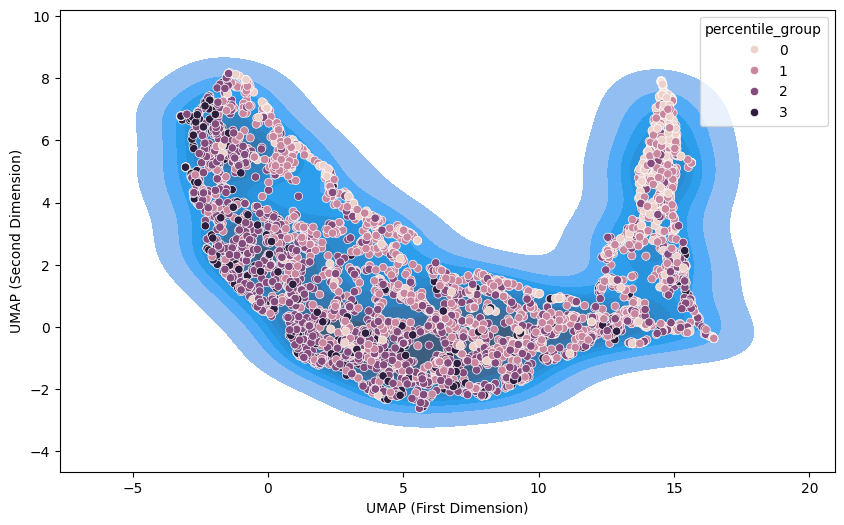

In [100]:
fig, ax= plt.subplots(figsize = (10,6))

sns.kdeplot(x = 'umap_x', y = 'umap_y', fill = True,data = umap_df, ax = ax)
sns.scatterplot(x = 'umap_x', y = 'umap_y', hue = 'percentile_group', data = umap_df, ax = ax)
ax.set_ylabel('UMAP (Second Dimension)')
ax.set_xlabel('UMAP (First Dimension)')
